# Predicting Diabetes Patient Readmission

### Importing Libraries

In [112]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import xgboost as xgb
import shap
import joblib

### Loading Dataset

In [ ]:
df=pd.read_csv('diabetic_data.csv')
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


### Feature Engineering

In [80]:
df.replace('?', np.nan, inplace=True)

In [81]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [82]:
df.drop(['weight','payer_code','medical_specialty','max_glu_serum','A1Cresult'],axis=1,inplace=True)

In [83]:
df.dropna(inplace=True)

In [84]:
df.shape

(98053, 45)

In [85]:
df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide

In [86]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,9.805300e+04,9.805300e+04,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000
mean,1.658294e+08,5.484792e+07,2.025813,3.753368,5.776692,4.421976,43.148073,1.350749,16.119650,0.376378,0.202462,0.646864,7.512060
std,1.024322e+08,3.866175e+07,1.450117,5.309392,4.071640,2.993074,19.712033,1.708506,8.108476,1.283359,0.942892,1.271020,1.832497
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,8.528566e+07,2.350234e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,1.533019e+08,4.687790e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.305007e+08,8.800306e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [87]:
admission_type_map = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    5: 'Not Available',
    6: 'NULL',
    7: 'Trauma Center',
    8: 'Not Mapped'
}
df['admission_type'] = df['admission_type_id'].map(admission_type_map)

In [88]:
admission_src_map = {
    1: 'Physician Referral',
    2: 'Clinic Referral',
    3: 'HMO Referral',
    4: 'Transfer from a hospital',
    5: 'Transfer from a Skilled Nursing Facility (SNF)',
    6: 'Transfer from another health care facility',
    7: 'Emergency Room',
    8: 'Court/Law Enforcement',
    9: 'Not Available',
    10: 'Transfer from critial access hospital',
    11: 'Normal Delivery',
    12: 'Premature Delivery',
    13: 'Sick Baby',
    14: 'Extramural Birth',
    15: 'Not Available',
    17: 'NULL',
    18: 'Transfer From Another Home Health Agency',
    19: 'Readmission to Same Home Health Agency',
    20: 'Not Mapped',
    21: 'Unknown/Invalid',
    22: 'Transfer from hospital inpt/same fac reslt in a sep claim',
    23: 'Born inside this hospital',
    24: 'Born outside this hospital',
    25: 'Transfer from Ambulatory Surgery Center',
    26: 'Transfer from Hospice'
}
df['admission_src'] = df['admission_source_id'].map(admission_src_map)

### Exploratory Data Analysis (EDA)

In [89]:
df['readmitted'] = df['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})

C:\Users\mahes\AppData\Local\Temp\ipykernel_37608\3610256316.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['readmitted'] = df['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})


In [90]:
df['readmitted'].value_counts()

readmitted
0    86987
1    11066
Name: count, dtype: int64

#### Numerical Data Analysis

Numerical features: ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'readmitted']


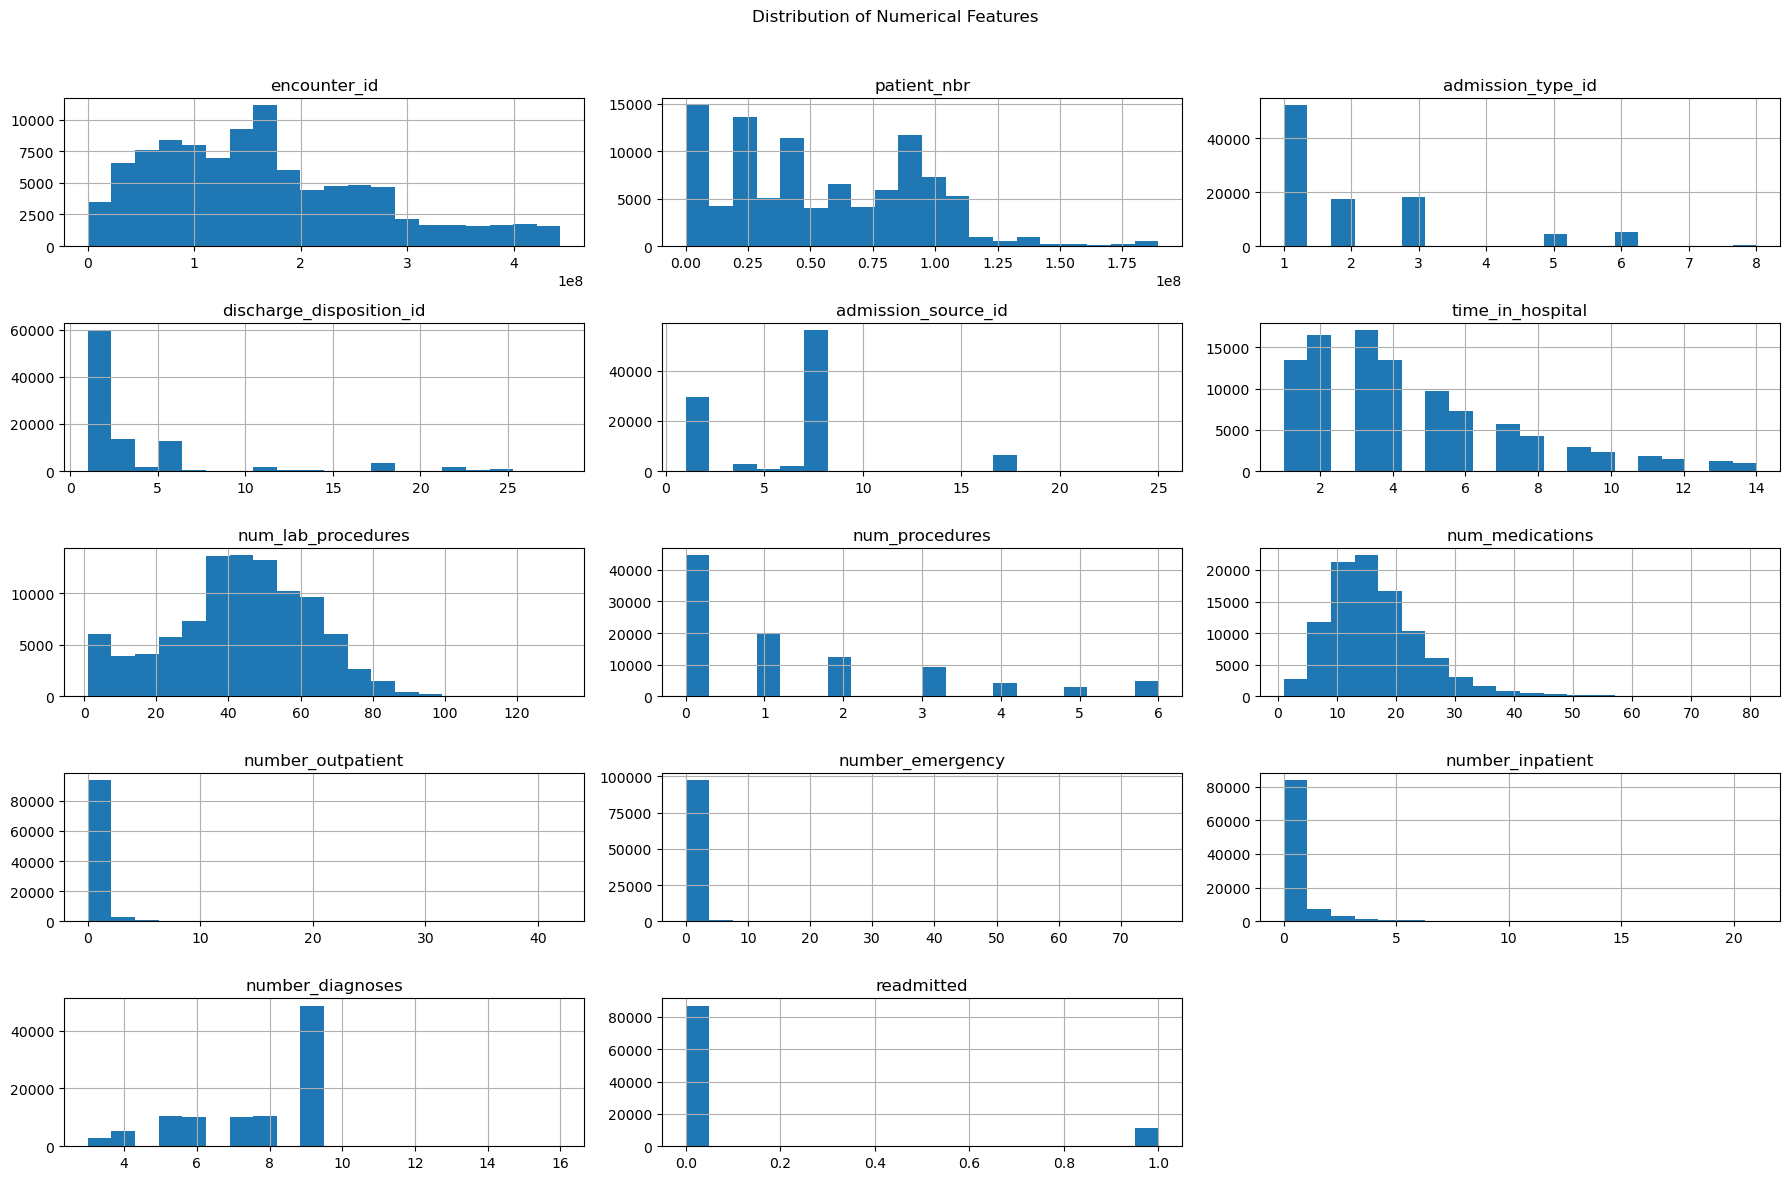

In [91]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Numerical features:", numerical_cols)
df[numerical_cols].hist(bins=20, figsize=(18, 12), layout=(5, 3))
plt.suptitle("Distribution of Numerical Features")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Correlation Heatmap for Numerical Features

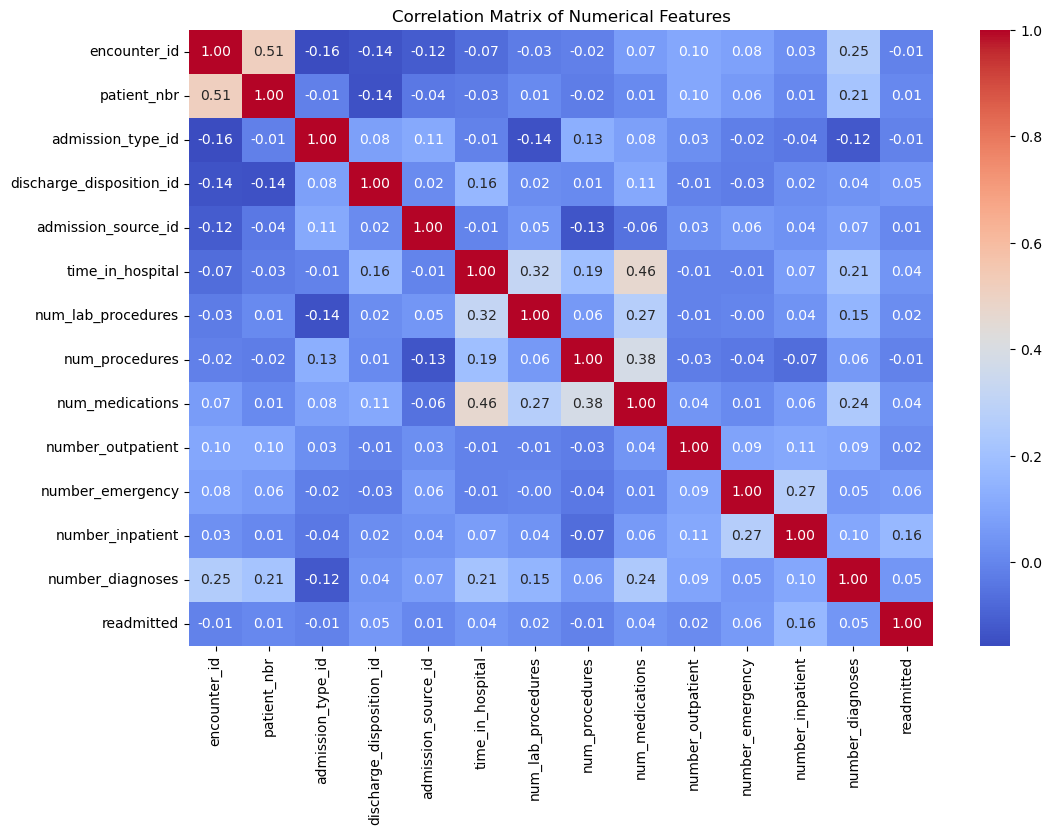

In [92]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [93]:
df.shape

(98053, 47)

In [94]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type', 'admission_src'],
      dtype='object')

In [95]:
df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type,admission_src
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,No,No,No,No,Ch,Yes,0,Emergency,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,Yes,0,Emergency,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,No,No,No,No,Ch,Yes,0,Emergency,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,No,No,No,No,Ch,Yes,0,Emergency,Emergency Room
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,No,No,No,No,No,Yes,0,Urgent,Clinic Referral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),1,3,7,3,51,...,No,No,No,No,No,Ch,Yes,0,Emergency,Emergency Room
101762,443847782,74694222,AfricanAmerican,Female,[80-90),1,4,5,5,33,...,No,No,No,No,No,No,Yes,0,Emergency,Transfer from a Skilled Nursing Facility (SNF)
101763,443854148,41088789,Caucasian,Male,[70-80),1,1,7,1,53,...,No,No,No,No,No,Ch,Yes,0,Emergency,Emergency Room
101764,443857166,31693671,Caucasian,Female,[80-90),2,3,7,10,45,...,No,No,No,No,No,Ch,Yes,0,Urgent,Emergency Room


#### Categorical Feature Analysis vs. Target

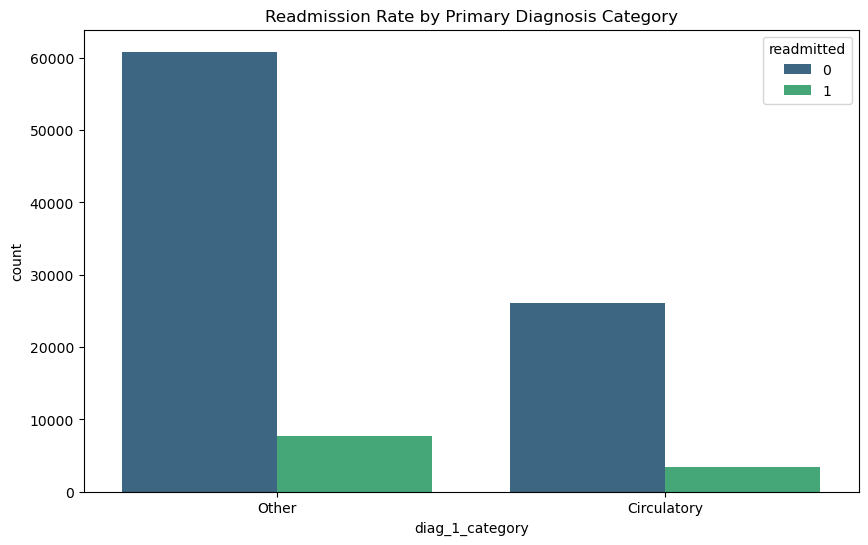

In [96]:
df_temp_diag=df.copy()
def diag_category(x):
	try:
		val = float(x)
		if 390 <= val <= 459:
			return 'Circulatory'
		else:
			return 'Other'
	except ValueError:
		return 'Other'

df_temp_diag['diag_1_category']=df_temp_diag['diag_1'].apply(diag_category)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_temp_diag,x='diag_1_category',hue='readmitted',palette='viridis')
plt.title('Readmission Rate by Primary Diagnosis Category')
plt.show()

#### Analyze medication changes vs. readmission

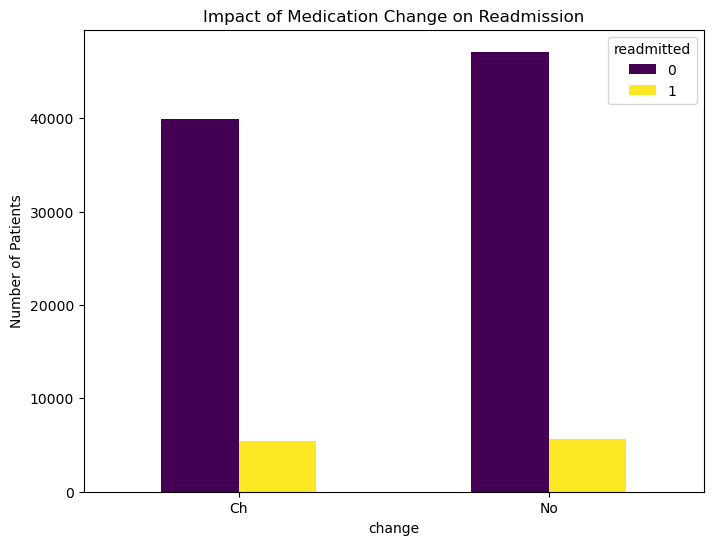

In [97]:
med_change_crosstab = pd.crosstab(df['change'], df['readmitted'])
med_change_crosstab.plot(kind='bar', stacked=False, figsize=(8, 6), colormap='viridis')
plt.title('Impact of Medication Change on Readmission')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

#### Analyze the distribution of 'time_in_hospital'

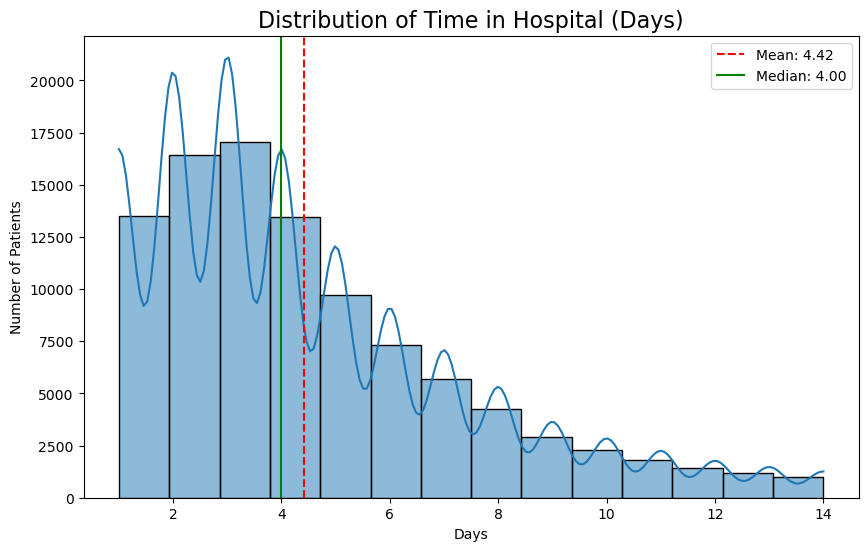

In [98]:
plt.figure(figsize=(10, 6))
sns.histplot(df['time_in_hospital'], kde=True, bins=14)
plt.title('Distribution of Time in Hospital (Days)', fontsize=16)
plt.xlabel('Days')
plt.ylabel('Number of Patients')
plt.axvline(df['time_in_hospital'].mean(), color='red', linestyle='--', label=f'Mean: {df.time_in_hospital.mean():.2f}')
plt.axvline(df['time_in_hospital'].median(), color='green', linestyle='-', label=f'Median: {df.time_in_hospital.median():.2f}')
plt.legend()
plt.show()

#### Numerical vs. Target

C:\Users\mahes\AppData\Local\Temp\ipykernel_37608\3423399799.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Not Readmitted (<30d)', 'Readmitted (<30d)'])
C:\Users\mahes\AppData\Local\Temp\ipykernel_37608\3423399799.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Not Readmitted (<30d)', 'Readmitted (<30d)'])


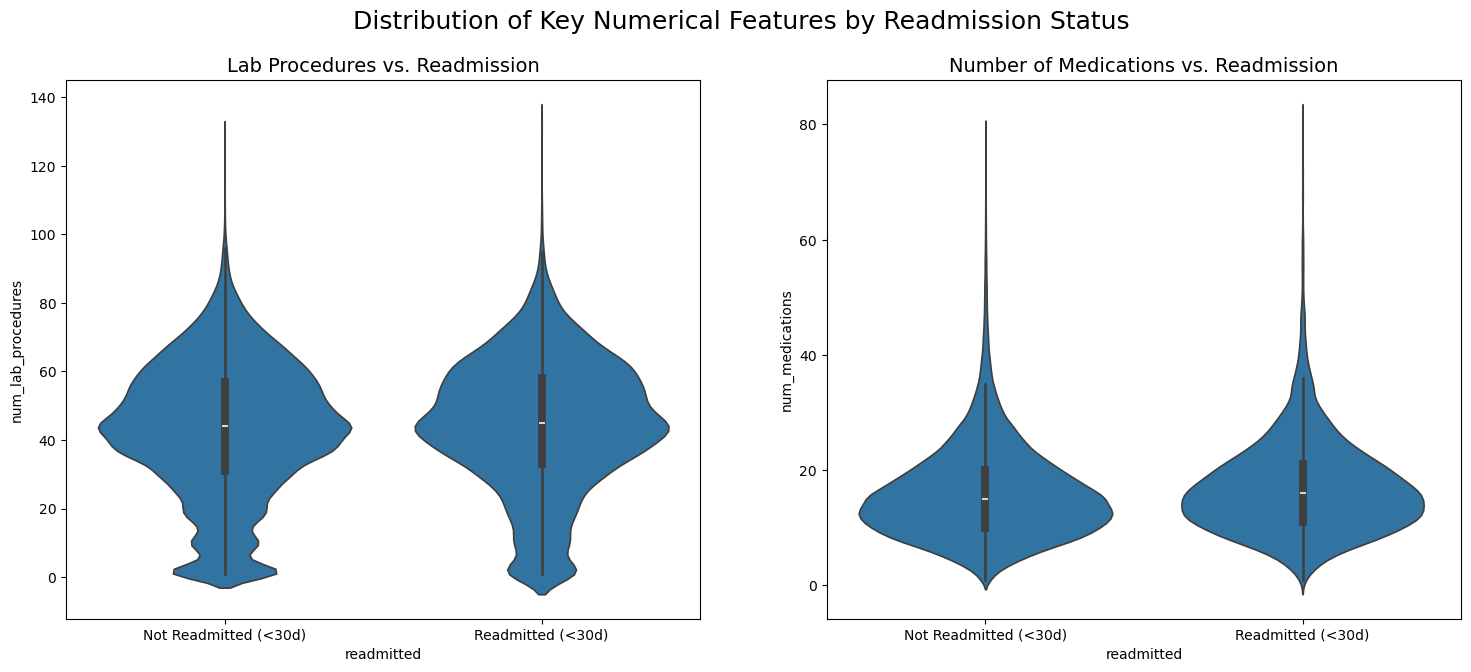

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.violinplot(ax=axes[0], x='readmitted', y='num_lab_procedures', data=df)
axes[0].set_title('Lab Procedures vs. Readmission', fontsize=14)
axes[0].set_xticklabels(['Not Readmitted (<30d)', 'Readmitted (<30d)'])

sns.violinplot(ax=axes[1], x='readmitted', y='num_medications', data=df)
axes[1].set_title('Number of Medications vs. Readmission', fontsize=14)
axes[1].set_xticklabels(['Not Readmitted (<30d)', 'Readmitted (<30d)'])
plt.suptitle('Distribution of Key Numerical Features by Readmission Status', fontsize=18)
plt.show()


#### Categorical vs. Target: Calculating Readmission Rates

In [100]:
def plot_readmission_rate(column_name, title, figsize=(8, 4)):
    """Helper function to plot readmission rates for a categorical feature."""
    # Calculate readmission rate for each category
    rate_df = df.groupby(column_name)['readmitted'].value_counts(normalize=True).unstack()
    rate_df = rate_df.rename(columns={1: 'Readmitted_Rate'})
    
    if 'Readmitted_Rate' not in rate_df.columns:
        print(f"No readmissions for any category in {column_name}. Skipping plot.")
        return
        
    rate_df = rate_df.sort_values(by='Readmitted_Rate', ascending=False)
    
    plt.figure(figsize=figsize)
    sns.barplot(x=rate_df.index, y=rate_df['Readmitted_Rate'], palette='plasma', order=rate_df.index,hue=rate_df.index,legend=False)
    plt.title(title, fontsize=16)
    plt.ylabel('Readmission Rate (<30 days)')
    plt.xlabel(column_name)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

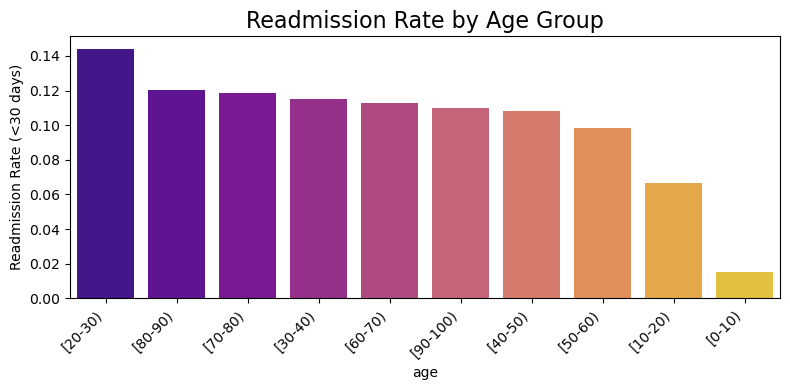

In [101]:
plot_readmission_rate('age', 'Readmission Rate by Age Group')

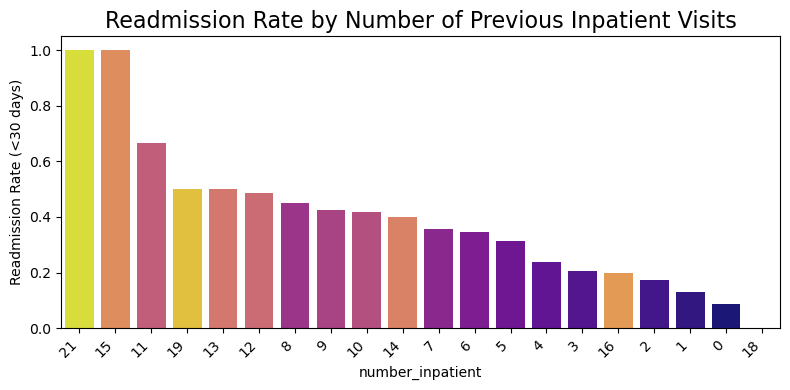

In [102]:
plot_readmission_rate('number_inpatient','Readmission Rate by Number of Previous Inpatient Visits')

#### Interaction between Age, Time in Hospital, and Readmission

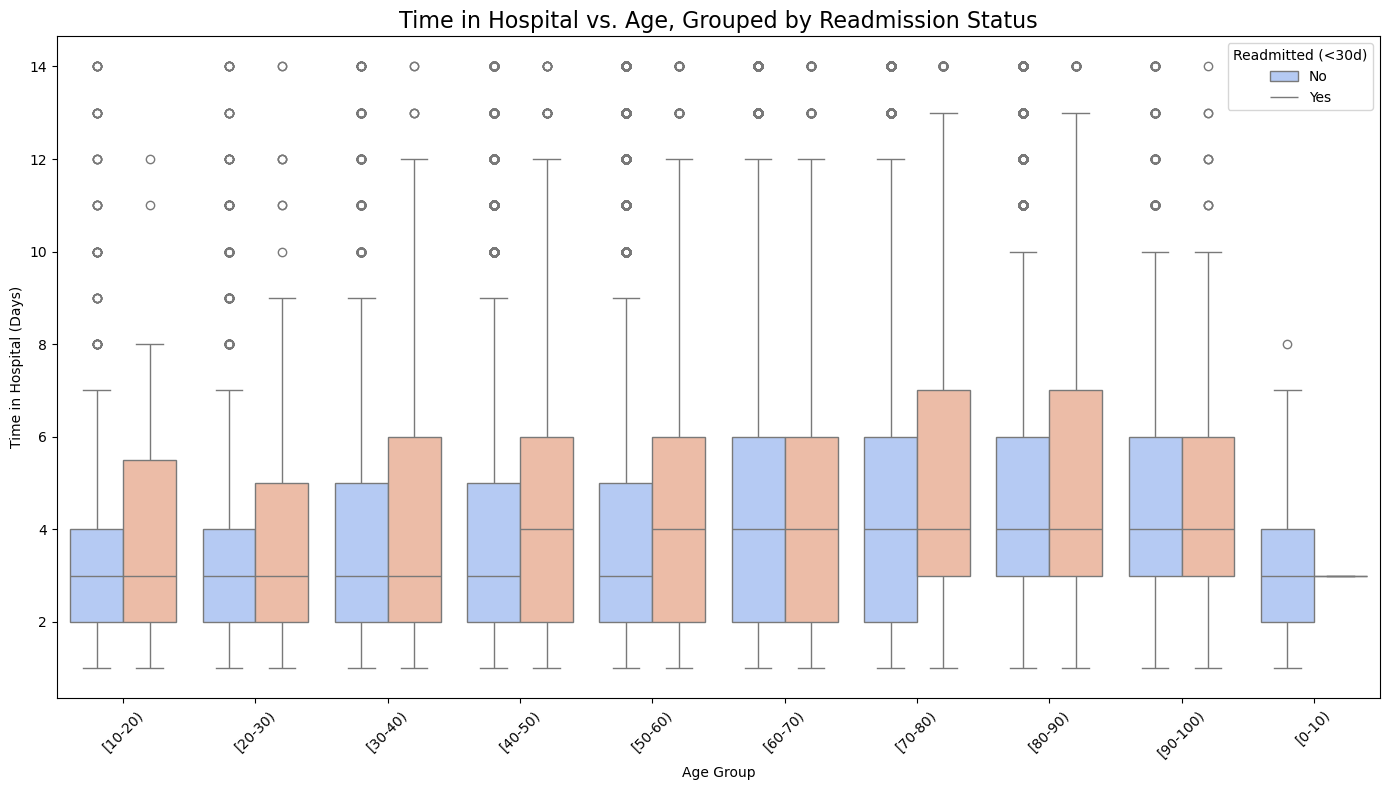

Insight: This plot helps see if longer stays for certain age groups lead to higher readmission rates.


In [103]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='age', y='time_in_hospital', hue='readmitted', palette='coolwarm')
plt.title('Time in Hospital vs. Age, Grouped by Readmission Status', fontsize=16)
plt.xlabel('Age Group')
plt.ylabel('Time in Hospital (Days)')
plt.xticks(rotation=45)
plt.legend(title='Readmitted (<30d)', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()
print("Insight: This plot helps see if longer stays for certain age groups lead to higher readmission rates.")


#### Interaction between Insulin Prescription Status and Readmission

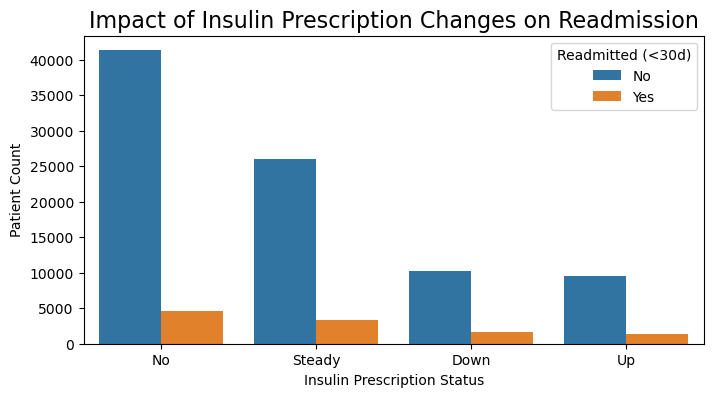

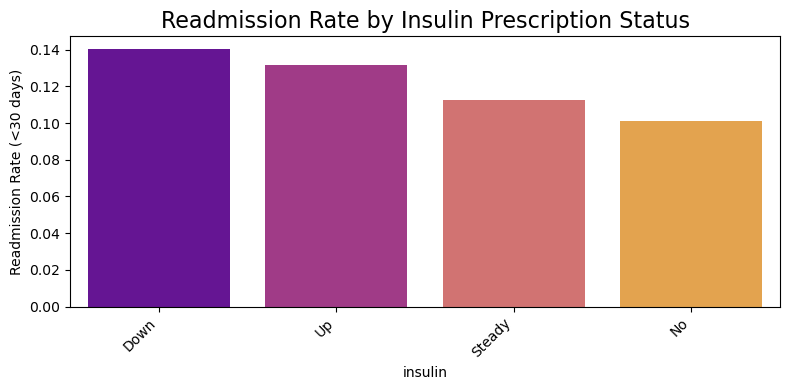

Insight: Patients whose insulin dosage was changed ('Up' or 'Down') may have higher readmission rates, suggesting instability.


In [104]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='insulin', hue='readmitted', order=['No', 'Steady', 'Down', 'Up'])
plt.title('Impact of Insulin Prescription Changes on Readmission', fontsize=16)
plt.xlabel('Insulin Prescription Status')
plt.ylabel('Patient Count')
plt.legend(title='Readmitted (<30d)', labels=['No', 'Yes'])
plt.show()
# Also plot this as a rate for clearer insight
plot_readmission_rate('insulin', 'Readmission Rate by Insulin Prescription Status')
print("Insight: Patients whose insulin dosage was changed ('Up' or 'Down') may have higher readmission rates, suggesting instability.")


#### Statistical Significance Testing

In [105]:
from scipy.stats import chi2_contingency, mannwhitneyu

contingency_table = pd.crosstab(df['gender'], df['readmitted'])
chi2, p_val, _, _ = chi2_contingency(contingency_table)
print(f"\nChi-Squared Test for Gender vs. Readmission:")
print(f"P-value: {p_val:.4f}")
if p_val < 0.05:
    print("Result: Significant association found. Gender is likely a predictive feature.")
else:
    print("Result: No significant association found.")


readmitted_group = df[df['readmitted'] == 1]['time_in_hospital']
not_readmitted_group = df[df['readmitted'] == 0]['time_in_hospital']

u_stat, p_val = mannwhitneyu(readmitted_group, not_readmitted_group)
print(f"\nMann-Whitney U Test for Time in Hospital vs. Readmission:")
print(f"P-value: {p_val:.4e}") # Using scientific notation for very small p-values
if p_val < 0.05:
    print("Result: Significant difference found. The time spent in the hospital is a strong predictor of readmission.")
else:
    print("Result: No significant difference found.")


Chi-Squared Test for Gender vs. Readmission:
P-value: 0.6832
Result: No significant association found.

Mann-Whitney U Test for Time in Hospital vs. Readmission:
P-value: 6.9725e-55
Result: Significant difference found. The time spent in the hospital is a strong predictor of readmission.


#### Feature Interaction Heatmap

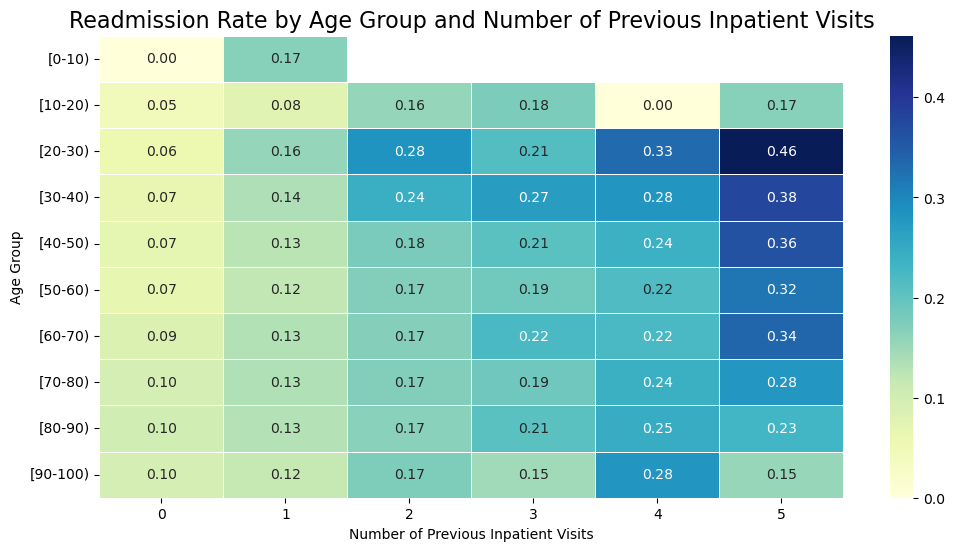


Insight: The heatmap clearly shows that the risk of readmission escalates dramatically for older patients who have had at least one prior inpatient visit in the last year.


In [108]:
pivot_table = df.pivot_table(values='readmitted', 
                             index='age', 
                             columns='number_inpatient', 
                             aggfunc='mean')

pivot_table = pivot_table.iloc[:, :6] 

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Readmission Rate by Age Group and Number of Previous Inpatient Visits', fontsize=16)
plt.xlabel('Number of Previous Inpatient Visits')
plt.ylabel('Age Group')
plt.show()

print("\nInsight: The heatmap clearly shows that the risk of readmission escalates dramatically for older patients who have had at least one prior inpatient visit in the last year.")

#### Aggregate Medication Analysis 


--- 3. Aggregate Medication Analysis ---
Feature 'med_changes' created.
med_changes
0    71311
1    25349
2     1281
3      107
4        5
Name: count, dtype: int64


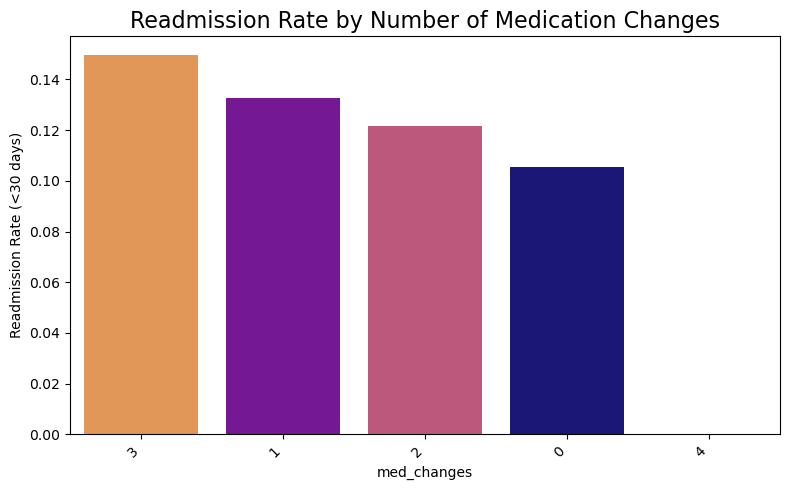


Insight: The readmission rate clearly increases with the number of medication changes, suggesting patient instability is a major risk factor.


In [ ]:
med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
            'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose',
            'miglitol', 'insulin', 'glyburide-metformin', 'glipizide-metformin']

# Count how many medications had a dosage change ('Up' or 'Down')
df['med_changes'] = 0
for col in med_cols:
    df['med_changes'] += df[col].isin(['Up', 'Down']).astype(int)

print("Feature 'med_changes' created.")
print(df['med_changes'].value_counts())

plot_readmission_rate('med_changes', 'Readmission Rate by Number of Medication Changes', figsize=(8,5))
print("\nInsight: The readmission rate clearly increases with the number of medication changes, suggesting patient instability is a major risk factor.")

#### PCA

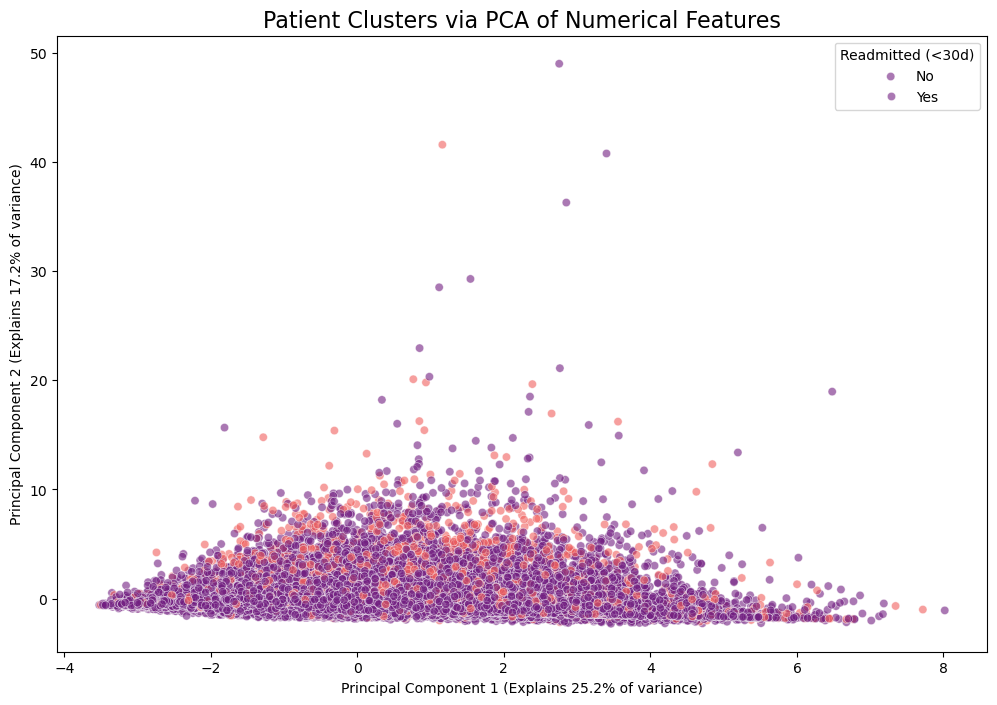


Insight: While there isn't a perfect separation, the plot shows that the readmitted patients (brighter dots) are not randomly scattered but tend to cluster in certain areas. This confirms that the numerical features, when combined, hold a signal that a machine learning model can learn.


In [113]:
numerical_features_original = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                               'num_medications', 'number_outpatient', 'number_emergency', 
                               'number_inpatient', 'number_diagnoses']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numerical_features_original])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['readmitted'] = df['readmitted'].values 

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='readmitted', data=pca_df, alpha=0.6, palette='magma')
plt.title('Patient Clusters via PCA of Numerical Features', fontsize=16)
plt.xlabel(f'Principal Component 1 (Explains {pca.explained_variance_ratio_[0]:.1%} of variance)')
plt.ylabel(f'Principal Component 2 (Explains {pca.explained_variance_ratio_[1]:.1%} of variance)')
plt.legend(title='Readmitted (<30d)', labels=['No', 'Yes'])
plt.show()

print("\nInsight: While there isn't a perfect separation, the plot shows that the readmitted patients (brighter dots) are not randomly scattered but tend to cluster in certain areas. This confirms that the numerical features, when combined, hold a signal that a machine learning model can learn.")

#### High-Level Overview: Patient Entry Points

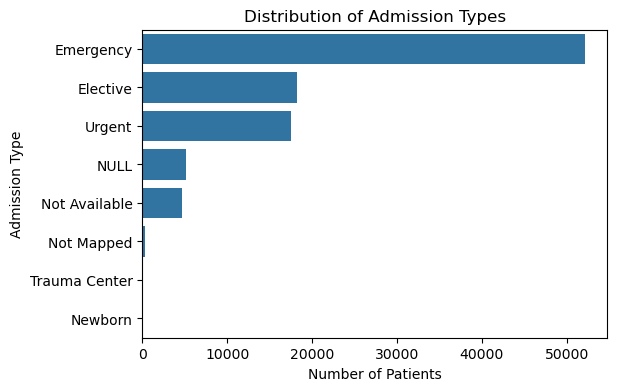

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df,y='admission_type',order=df['admission_type'].value_counts().index)
plt.title('Distribution of Admission Types',fontsize=12)
plt.xlabel('Number of Patients')
plt.ylabel('Admission Type')
plt.show()

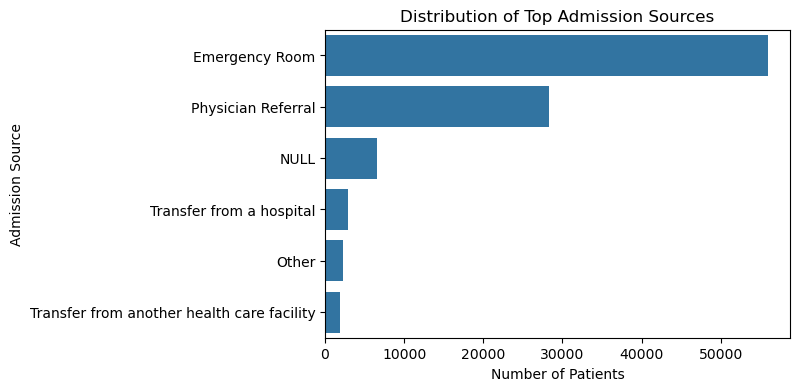


Insight: This quickly shows that 'Emergency' admissions and 'Emergency Room' or 'Physician Referral' are the dominant pathways.


In [120]:
top_sources=df['admission_src'].value_counts().nlargest(5).index
df['admission_src_grouped']=df['admission_src'].apply(lambda x: x if x in top_sources else 'Other')

plt.figure(figsize=(6,4))
sns.countplot(data=df,y='admission_src_grouped',order=df['admission_src_grouped'].value_counts().index)
plt.title('Distribution of Top Admission Sources',fontsize=12)
plt.xlabel('Number of Patients')
plt.ylabel('Admission Source')
plt.show()

print("\nInsight: This quickly shows that 'Emergency' admissions and 'Emergency Room' or 'Physician Referral' are the dominant pathways.")

#### Core Analysis: Impact on Readmission Rate

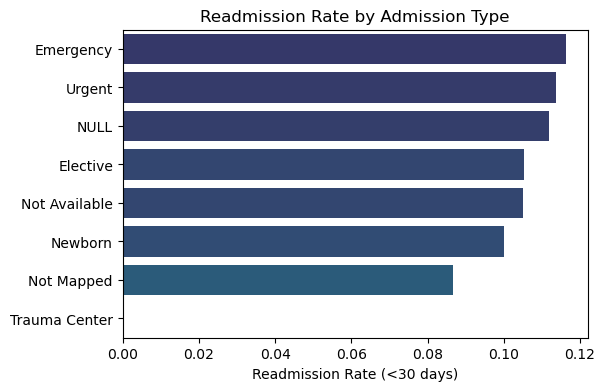

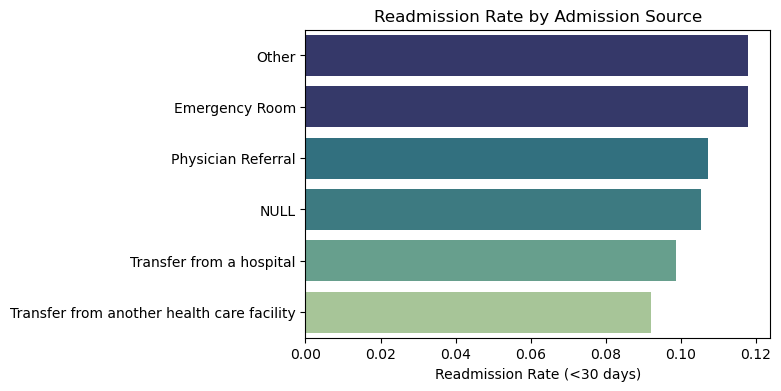


Hypothesis Check: We can now verify if 'Emergency' admissions or referrals from other facilities (grouped in 'Other') indeed have higher readmission rates.


In [123]:
def plot_readmission_rate(df, column_name,title):
    """Helper function to plot readmission rates for a categorical feature."""
    rate_df=df.groupby(column_name)['readmitted'].value_counts(normalize=True).unstack().fillna(0)
    rate_df=rate_df.rename(columns={1:'Readmission_Rate'})
    rate_df=rate_df.sort_values(by='Readmission_Rate',ascending=False)
    
    plt.figure(figsize=(6,4))
    sns.barplot(x=rate_df['Readmission_Rate'],y=rate_df.index,
                palette='crest',orient='h',hue=rate_df['Readmission_Rate'],legend=False)
    plt.title(title,fontsize=12)
    plt.xlabel('Readmission Rate (<30 days)')
    plt.ylabel('')
    plt.show()

# Plot for Admission Type
plot_readmission_rate(df,'admission_type','Readmission Rate by Admission Type')

# Plot for Admission Source
plot_readmission_rate(df,'admission_src_grouped','Readmission Rate by Admission Source')

print("\nHypothesis Check: We can now verify if 'Emergency' admissions or referrals from other facilities (grouped in 'Other') indeed have higher readmission rates.")

#### Interaction Analysis: Combining Source and Type

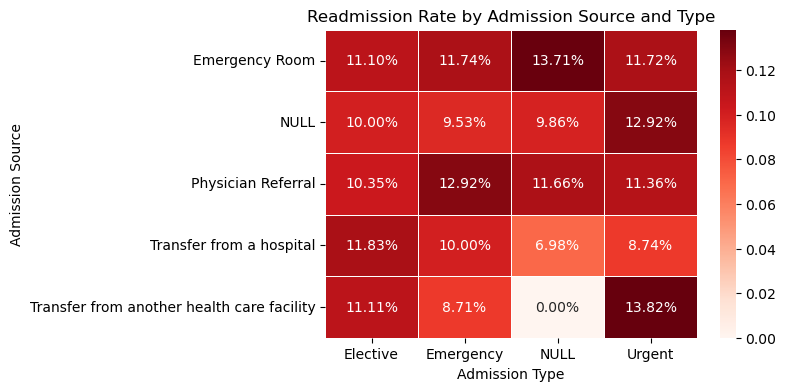


Insight: This heatmap can pinpoint very specific high-risk pathways, such as 'Urgent' admissions that came from 'Transfer from a hospital', which your model can leverage.


In [127]:
top_types=df['admission_type'].value_counts().nlargest(4).index
df_filtered=df[(df['admission_src_grouped'] !='Other')&(df['admission_type'].isin(top_types))]

# Create the pivot table
interaction_pivot=df_filtered.pivot_table(
    values='readmitted',
    index='admission_src_grouped',
    columns='admission_type',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(6,4))
sns.heatmap(interaction_pivot,annot=True,fmt=".2%",cmap="Reds",linewidths=.5)
plt.title('Readmission Rate by Admission Source and Type',fontsize=12)
plt.xlabel('Admission Type')
plt.ylabel('Admission Source')
plt.show()

print("\nInsight: This heatmap can pinpoint very specific high-risk pathways, such as 'Urgent' admissions that came from 'Transfer from a hospital', which your model can leverage.")

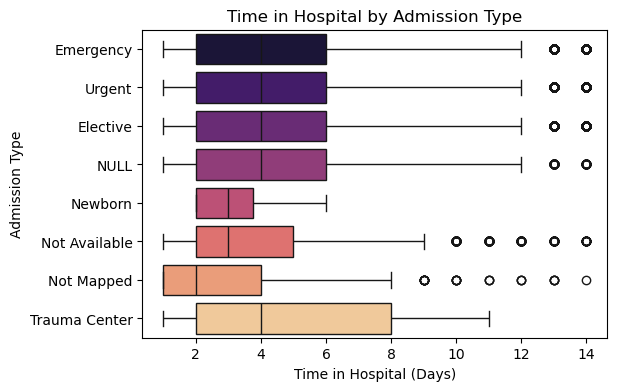

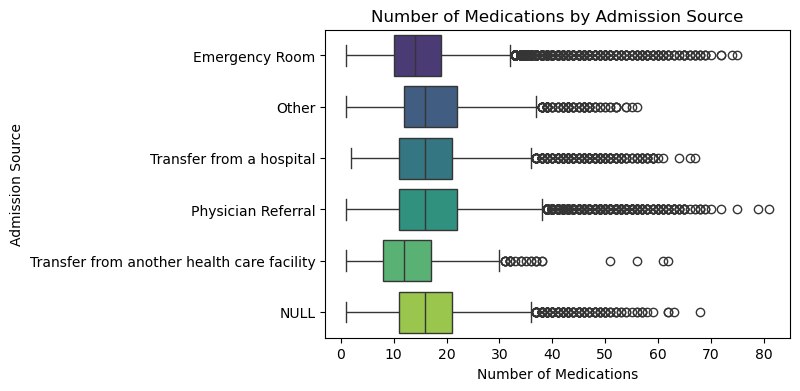


Insight: This can reveal if patients from, for example, the 'Emergency Room' typically stay longer or are on more medications, indicating higher initial acuity.


In [131]:
# --- Admission Type vs. Time in Hospital ---
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='time_in_hospital',y='admission_type',
            palette='magma',hue='admission_type',legend=False)
plt.title('Time in Hospital by Admission Type',fontsize=12)
plt.xlabel('Time in Hospital (Days)')
plt.ylabel('Admission Type')
plt.show()

# --- Admission Source vs. Number of Medications ---
plt.figure(figsize=(6,4))
sns.boxplot(data=df,x='num_medications',y='admission_src_grouped',
            palette='viridis',hue='admission_src_grouped',legend=False)
plt.title('Number of Medications by Admission Source',fontsize=12)
plt.xlabel('Number of Medications')
plt.ylabel('Admission Source')
plt.show()

print("\nInsight: This can reveal if patients from, for example, the 'Emergency Room' typically stay longer or are on more medications, indicating higher initial acuity.")

In [132]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type', 'admission_src', 'med_changes',
       'admission_src_grouped'],
      dtype='object')

In [134]:
df.to_csv('final_dataset.csv',index=False)